# Basic ZNE
### Using Qiskit and Sickit-learn

<b>ZNE:</b> Zero Noise Extrapolation is a technique for mitigating noise on quantum computers.<br>
Note that noise mitigation differs from error correction.<br>
<b>Error correction:</b> Fully corrects the errors, in contrast with mitigation that makes the errors less.

### Outline of the notebook

<ul>
    <li>Functions used</li>
    <li>example 1</li>
    <li>example 2</li>
</ul>

In [1]:
!pip install -U scikit-learn

In [2]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [3]:
import qiskit
from qiskit.opflow import CircuitStateFn

/tmp/ipykernel_32391/3231869178.py:2: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import CircuitStateFn


In [4]:
from qiskit import *
import numpy as np
from qiskit.opflow import X, Y, Z, I

### Functions used:

To summarize the steps that will be used for ZNE: a quantum circuit is first created then it is entered as a parameter into a function that returns a circuit with only the error gates. Then this returned circuit with only the error gates is appended to the end of the created original circuit. Then we calculate the expected value. We repeat this step for different circuits each folded several number of times(odd times, more about that later). Then in the end after calculating the results for every circuit we use extrapolation to find the real or near the real value. 

First a circuit with random parameters for its gates is created, you can create any circuit you want.

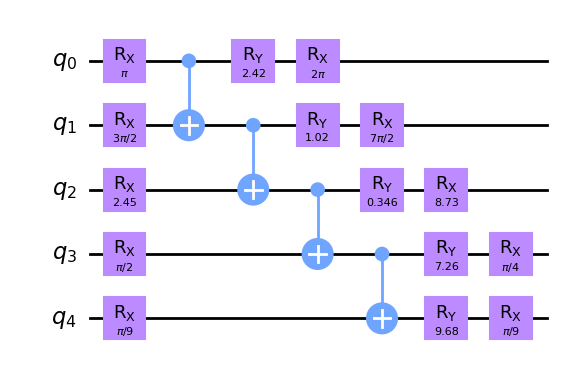

In [5]:
qc = QuantumCircuit(5)

qc.rx(np.pi, 0)
qc.rx(3*np.pi/2, 1)
qc.rx(0.78*np.pi, 2)
qc.rx(np.pi/2, 3)
qc.rx(np.pi/9, 4)

qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)
qc.cx(3, 4)

qc.ry(0.77*np.pi, 0)
qc.ry(0.65*np.pi/2, 1)
qc.ry(0.77*np.pi/7, 2)
qc.ry(3*0.77*np.pi, 3)
qc.ry(4*0.77*np.pi, 4)

qc.rx(2*np.pi, 0)
qc.rx(7*np.pi/2, 1)
qc.rx(2.78*np.pi, 2)
qc.rx(np.pi/4, 3)
qc.rx(np.pi/9, 4)

qc.draw("mpl")

The "depolarizationErrors" function takes the created circuit to create a new circuit with the same number of qubits  that contains only error gates.

But what type of error is used?<br>
<b>Depolarizing error:</b> Is an error type that adds an X, Y or Z gate to a qubit with certain probability.

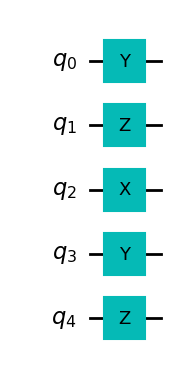

In [6]:
def depolarizationErrors(qc):
    errors = ['X', 'Y', 'Z']
    number_of_qubits = len(qc.qubits) 
    circuit = QuantumCircuit(number_of_qubits)
    for i in range(number_of_qubits):
      if np.random.randint(100) < 90:
          choice = np.random.choice(errors)
          if (choice == 'X'):
            circuit.x(i)
          elif (choice == 'Y'):
            circuit.y(i)
          else:
            circuit.z(i)
    return circuit
x = depolarizationErrors(qc)
x.draw('mpl')

In this function "generateObservable" a random observable is generated.<br>
<b>n_qubits:</b> is the number of qubits of our circuit<br>
<b>n_terms:</b> is the number of terms we have in our observable. Note that since the terms are generated randomly, sometimes similar terms might be added and we might get a number of terms less than what is expected.

In [7]:
def generateObservable(n_qubits, n_terms):
    op = 0
    for _ in range(n_terms):
        term_list = []
        for __ in range(n_qubits):
            choice = np.random.choice(['X', 'Y', 'Z', 'I'])
            if (choice == 'X'):
                term_list.append(X)
            elif (choice == 'Y'):
                term_list.append(X)
            elif (choice == 'Z'):
                term_list.append(Z)
            else:
                term_list.append(I)
        combined = term_list[0]
        for i in range(1, len(term_list)):
            combined = combined^term_list[i]
        combined = np.random.uniform(-10, 4)*combined
        op = op + combined
    return op
op = generateObservable(5, 7)

In [8]:
print(op)

-9.168546160145977 * IZXII
- 0.08789260516849318 * XXXII
+ 0.13462451136895304 * XXIXX
+ 0.6476661943968054 * ZZZXX
+ 0.4124136517024706 * IZZZX
- 7.284965532513596 * XXXXX
- 0.5709354497904311 * XXIII


Now it is important to get the real value without error to compare with our results.<br>
The following 2 cells find the expected value simply using the rule in the picture.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*EX2ZQgnlqt4X1jIcLlUPxg.png" alt="Alternative text"/>

In [9]:
psi = CircuitStateFn(qc)

/tmp/ipykernel_32391/958957006.py:1: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  psi = CircuitStateFn(qc)


We take our circuit, conjugate it(take its adjoint) then multiply by the operator and then by the circuit.

In [10]:
print('expected value', psi.adjoint().compose(op).compose(psi).eval().real)

expected value 0.607770954807556


In [11]:
def zne(qc, op, folding_factors):
    results = []
    circuits = []
    for fct in folding_factors:
        temp_circuit = QuantumCircuit(len(qc.qubits))
        ct = 1
        for _ in range(fct):
            temp_circuit.barrier(range(len(qc.qubits)))
            if ct%2 != 0:
                temp_circuit = temp_circuit.compose(qc)
            else:
                temp_circuit = temp_circuit.compose(qc.inverse())
            ct = ct + 1
        error_circuit = depolarizationErrors(temp_circuit)
        temp_circuit = temp_circuit.compose(error_circuit)
        circuits.append(temp_circuit)
        psi = CircuitStateFn(temp_circuit)
        results.append(psi.adjoint().compose(op).compose(psi).eval().real)
    return results, circuits

What happens now is that we use the zne function to prepare different circuits according to the folding_factors list. Then we return the results with the circuits.

In [13]:
values, y = zne(qc, op, [1, 3, 5, 7, 9, 11, 13])

/tmp/ipykernel_32391/3676094988.py:17: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  psi = CircuitStateFn(temp_circuit)


You can see above that folding factors are odd not even that is because we append the original circuit then the inverse, then the original and so on. But if the number is even then the circuits and its inverse will cancel each other, so we get an empty ciruit in the end. Also, note that we should start with the original circuit and not the inverse one.

In [14]:
values

[-0.2404476515238234,
 0.37863983927265904,
 0.15212120039216467,
 -0.24044765152382308,
 0.3786398392726593,
 -0.6021899074397118,
 -0.3786398392726592]

Some of the resultanr circuits can be seen here with error gates in the end.

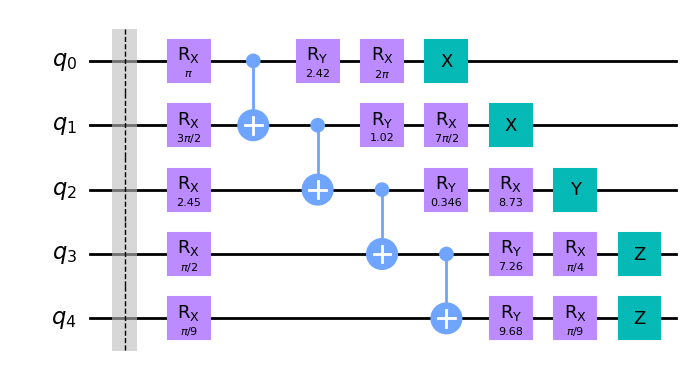

In [15]:
y[0].draw('mpl')

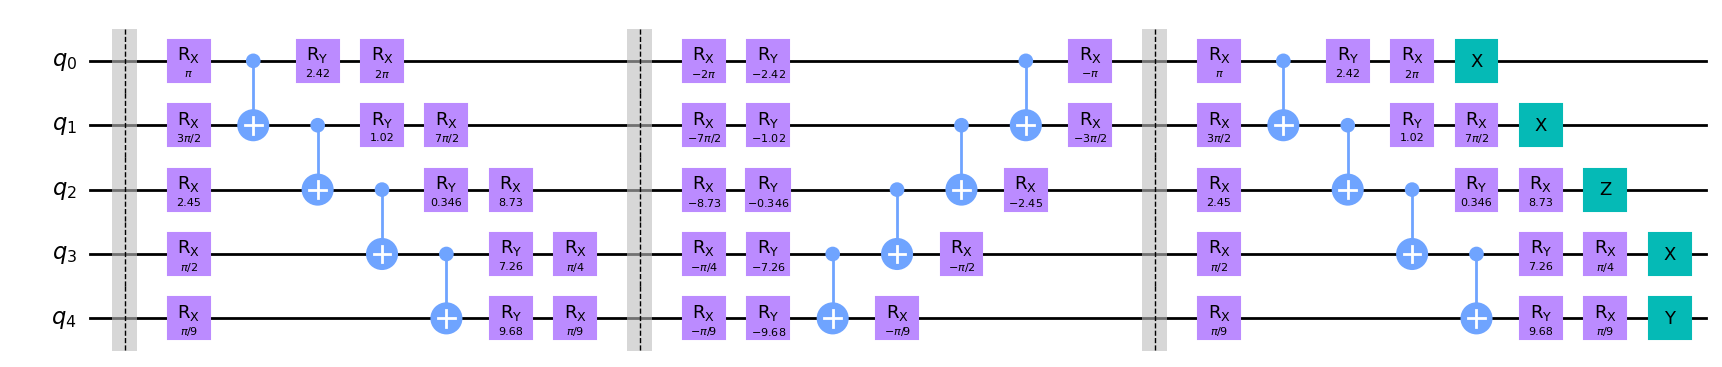

In [16]:
y[1].draw('mpl')

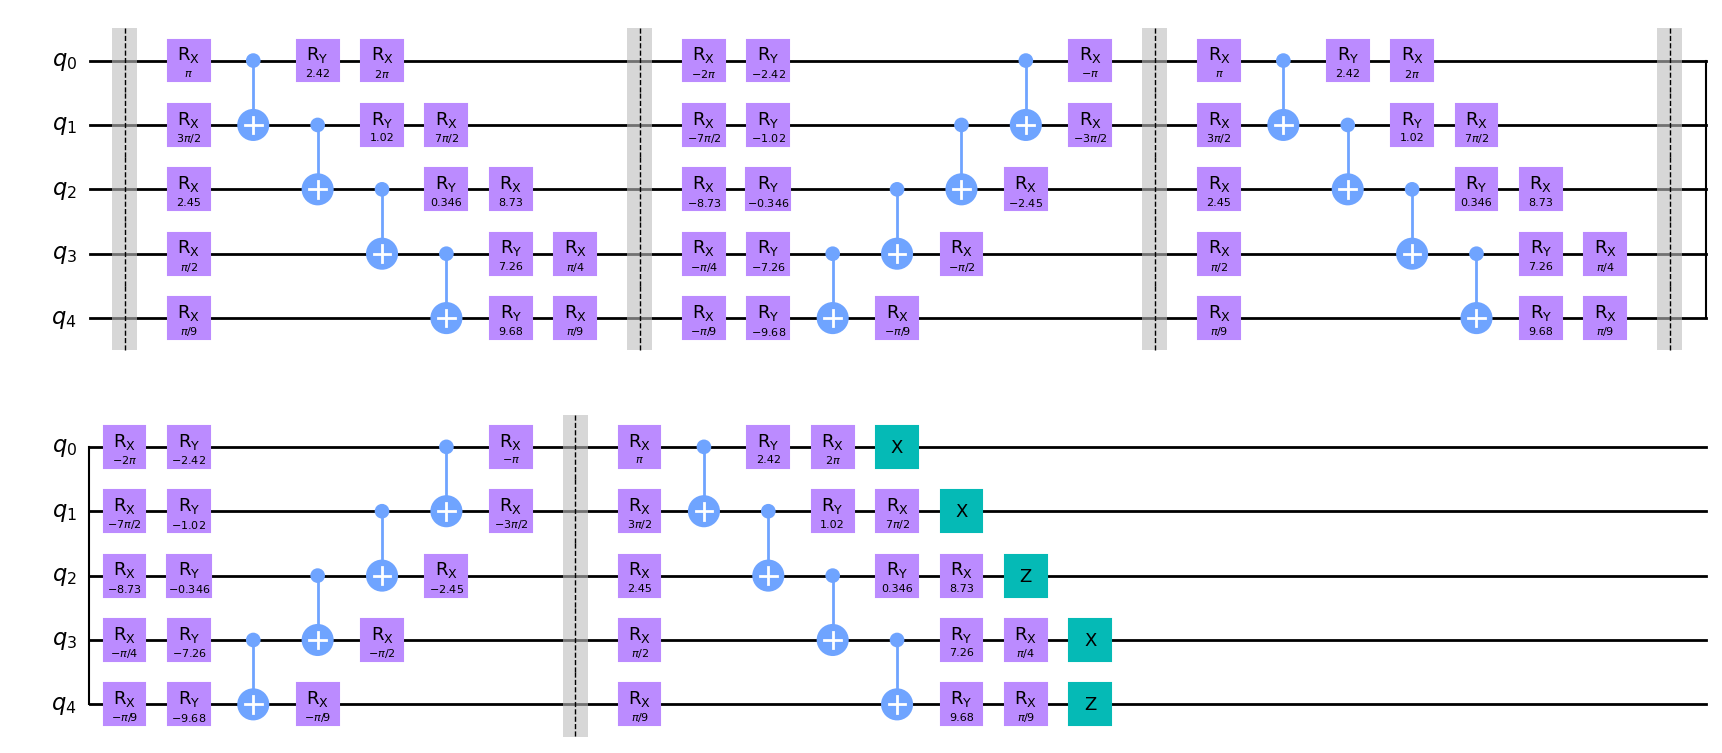

In [17]:
y[2].draw('mpl')

### Example 1:

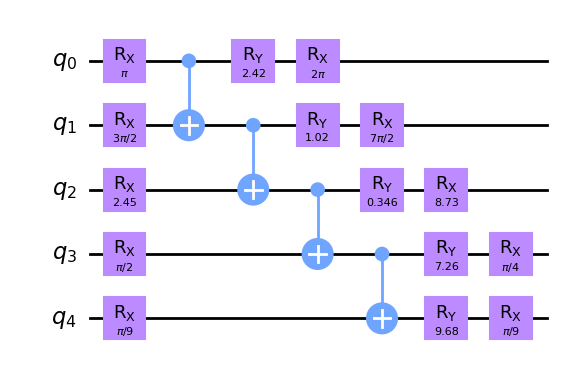

In [18]:
qc = QuantumCircuit(5)
qc.rx(np.pi, 0)
qc.rx(3*np.pi/2, 1)
qc.rx(0.78*np.pi, 2)
qc.rx(np.pi/2, 3)
qc.rx(np.pi/9, 4)

qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)
qc.cx(3, 4)

qc.ry(0.77*np.pi, 0)
qc.ry(0.65*np.pi/2, 1)
qc.ry(0.77*np.pi/7, 2)
qc.ry(3*0.77*np.pi, 3)
qc.ry(4*0.77*np.pi, 4)

qc.rx(2*np.pi, 0)
qc.rx(7*np.pi/2, 1)
qc.rx(2.78*np.pi, 2)
qc.rx(np.pi/4, 3)
qc.rx(np.pi/9, 4)

qc.draw("mpl")

In [19]:
op = generateObservable(5, 7)
print(op)

1.054968411412668 * XXZXX
- 0.4896532213366669 * IZXZZ
+ 1.0128112326290015 * XXXXX
- 1.4769106090979403 * XZXIZ
- 8.3185739162394 * XXXXI
- 0.9933892285399626 * XZXXX
- 3.612475454808618 * XXXIZ


In [20]:
psi = CircuitStateFn(qc)
print('expected value', psi.adjoint().compose(op).compose(psi).eval().real)

expected value -0.7817183531331354


/tmp/ipykernel_32391/1778758864.py:1: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  psi = CircuitStateFn(qc)


In [21]:
values, y = zne(qc, op, [1, 3, 5, 7, 9, 11, 13])

/tmp/ipykernel_32391/3676094988.py:17: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  psi = CircuitStateFn(temp_circuit)


In [22]:
values

[-0.7324597711582622,
 -0.7358146977968083,
 -0.3459405969007106,
 0.7348762065948305,
 0.7358146977968096,
 -0.7348762065948327,
 -0.1713436369360708]

In [23]:
x = np.array([1, 3, 5, 7, 9, 11, 13])

y = np.array(values)

In the following code the founded values will be plotted and then poylinomials of degrees from 1 to 5 will be used. Sickit-learn was used to fit the points and then the extrapolated or predicted values at 0 will be shown.

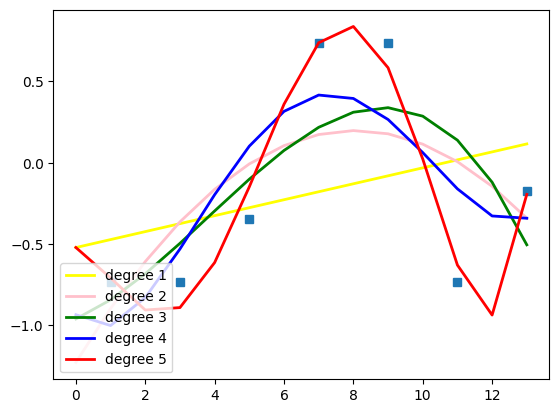

In [25]:
import matplotlib.pyplot as plt
x_plot = np.array(range(0, x[-1]+1)).reshape(-1, 1)
colors = ['yellow', 'pink', 'green', 'blue', 'red']
lw = 2
plt.plot(x, y, 's')
predicted = []
for count, degree in enumerate([1, 2, 3, 4, 5]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(x.reshape(-1, 1), y.reshape(-1, 1))
    y_plot = model.predict(x_plot)
    predicted.append([y_plot[0], colors[count]])
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw,
             label="degree %d" % degree)
plt.legend(loc="lower left")
plt.show()

In [26]:
predicted

[[array([-0.52134662]), 'yellow'],
 [array([-1.22749694]), 'pink'],
 [array([-0.96016018]), 'green'],
 [array([-0.93408363]), 'blue'],
 [array([-0.5211095]), 'red']]

expected value -0.7817183531331354

It is clear above that blue with degree 4 gave the nearest value to the expected.

### Example 2:

This example has the same steps as example 1 but just with a different circuit and operator.

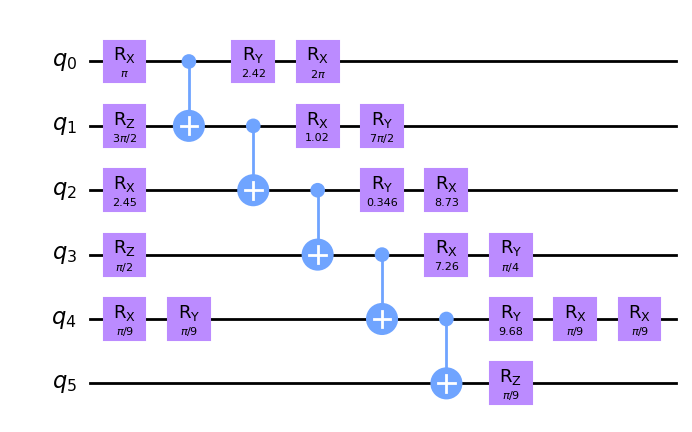

In [27]:
qc = QuantumCircuit(6)
qc.rx(np.pi, 0)
qc.rz(3*np.pi/2, 1)
qc.rx(0.78*np.pi, 2)
qc.rz(np.pi/2, 3)
qc.rx(np.pi/9, 4)
qc.ry(np.pi/9, 4)

qc.cx(0, 1)
qc.cx(1, 2)
qc.cx(2, 3)
qc.cx(3, 4)
qc.cx(4, 5)

qc.ry(0.77*np.pi, 0)
qc.rx(0.65*np.pi/2, 1)
qc.ry(0.77*np.pi/7, 2)
qc.rx(3*0.77*np.pi, 3)
qc.ry(4*0.77*np.pi, 4)
qc.rx(np.pi/9, 4)

qc.rx(2*np.pi, 0)
qc.ry(7*np.pi/2, 1)
qc.rx(2.78*np.pi, 2)
qc.ry(np.pi/4, 3)
qc.rx(np.pi/9, 4)
qc.rz(np.pi/9, 5)

qc.draw("mpl")

In [35]:
op = generateObservable(6, 9)
print(op)

-9.86386392816569 * XIIZZX
- 6.9979652049241405 * ZIXIXX
- 1.9192326671360096 * XIZXIX
- 9.809469813323759 * XZXIIX
- 6.875634910196693 * ZXIXXX
+ 1.3211662614728201 * XXIIZZ
- 4.817259480303457 * XZXIXI
- 5.238863633650162 * XXXXXZ
- 4.592685715016088 * XXXXXX


In [36]:
psi = CircuitStateFn(qc)
print('expected value', psi.adjoint().compose(op).compose(psi).eval().real)

expected value 0.6743407193932509


/tmp/ipykernel_32391/1778758864.py:1: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  psi = CircuitStateFn(qc)


In [37]:
values, y = zne(qc, op, [1, 3, 5, 7, 9])

/tmp/ipykernel_32391/3676094988.py:17: DeprecationWarning: The class ``qiskit.opflow.state_fns.circuit_state_fn.CircuitStateFn`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  psi = CircuitStateFn(temp_circuit)


In [38]:
values

[-0.4122529384226201,
 -1.2850156297370143,
 0.24112830848483663,
 0.7530112086694453,
 -0.06728724373278194]

In [39]:
x = np.array([1, 3, 5, 7, 9])

y = np.array(values)

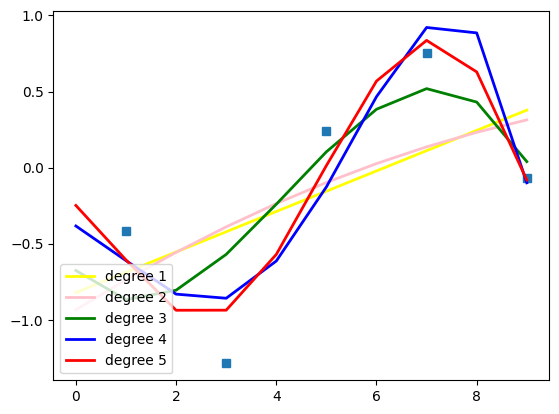

In [40]:
x_plot = np.array(range(0, x[-1]+1)).reshape(-1, 1)
colors = ['yellow', 'pink', 'green', 'blue', 'red']
lw = 2
plt.plot(x, y, 's')
predicted = []
for count, degree in enumerate([1, 2, 3, 4, 5]):
    model = make_pipeline(PolynomialFeatures(degree), Ridge())
    model.fit(x.reshape(-1, 1), y.reshape(-1, 1))
    y_plot = model.predict(x_plot)
    predicted.append([y_plot[0], colors[count]])
    plt.plot(x_plot, y_plot, color=colors[count], linewidth=lw,
             label="degree %d" % degree)
plt.legend(loc="lower left")
plt.show()

expected value 0.6743407193932509

In [42]:
predicted

[[array([-0.81943892]), 'yellow'],
 [array([-0.93228448]), 'pink'],
 [array([-0.67465698]), 'green'],
 [array([-0.38243333]), 'blue'],
 [array([-0.24761768]), 'red']]

This time we can see that red with degree 5 gave the best value.

### references:
<ul>
    <li>Qiskit documentation</li>
    <li>Mitiq documentation</li>
    <li>Sickit-learn: https://scikit-learn.org/0.24/auto_examples/linear_model/plot_polynomial_interpolation.html</li>
    <li>https://mljar.com/blog/jupyter-notebook-insert-image/</li>
</ul>